In [1]:
# REQUIRED LIBRARIES

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datetime import datetime, timedelta
import os
import logging
from entmax import sparsemax  


/home/rsarkar/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Set device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(filename='portfolio_optimization.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s')

In [4]:
# Data Preprocessing

In [5]:
def load_and_preprocess_data(file_paths, seq_len=10, date_column='Date', feature_columns=['Open', 'Close', 'High', 'Low']):
    dfs = []
    for file in file_paths:
        df = pd.read_excel(file)
        df.columns = df.columns.str.strip().str.lower()
        required_columns = [date_column.lower()] + [col.lower() for col in feature_columns]

        def convert_date(date):
            if isinstance(date, (int, float)):
                base_date = datetime(1899, 12, 30)
                return pd.to_datetime(base_date + timedelta(days=date))
            elif isinstance(date, pd.Timestamp):
                return date
            else:
                return pd.to_datetime(date, errors='coerce')

        df['date'] = df['date'].apply(convert_date)
        df = df.set_index('date')

        for col in feature_columns:
            df[col.lower()] = df[col.lower()].round(2)

        if 'volume' in df.columns:
            df = df[df['volume'] != 0]
            df = df.drop(columns=['volume'])

        df = df[required_columns[1:]].dropna()
        dfs.append(df)

    common_dates = pd.concat([df[['close']] for df in dfs], axis=1).dropna().index
    dfs = [df.loc[common_dates] for df in dfs]

    data = np.stack([df[[col.lower() for col in feature_columns]].values for df in dfs], axis=1)
    sequences = [data[i:i + seq_len] for i in range(len(data) - seq_len + 1)]
    sequences = torch.tensor(np.array(sequences), dtype=torch.float32).to(device)
    print(f"Final sequence tensor shape: {sequences.shape}")
    return sequences


In [6]:
# Dilated Causal Convolution Layer

In [7]:
class DCC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(DCC, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=(kernel_size - 1) * dilation, dilation=dilation)
        self.kernel_size = kernel_size
        self.dilation = dilation

    def forward(self, x):
        x = self.conv(x)
        padding = (self.kernel_size - 1) * self.dilation
        x = x[:, :, :-padding] if padding > 0 else x
        return F.relu(x)


In [8]:
# Graph Attention Layer

In [9]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(GATLayer, self).__init__()
        self.Wg = nn.Linear(in_features, out_features, bias=False)
        self.Wa = nn.Linear(2 * in_features, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, node_features, edge_info):
        batch_size, num_nodes, in_features = node_features.size()
        h = self.Wg(node_features)

        attention = torch.zeros(batch_size, num_nodes, num_nodes, device=node_features.device)
        for i in range(num_nodes):
            for j in range(num_nodes):
                concat_features = torch.cat([node_features[:, i, :], node_features[:, j, :]], dim=-1)
                gate = torch.tanh(self.Wa(concat_features))
                attention[:, i, j] = edge_info[:, i, j] * gate.squeeze()

        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)

        h_prime = torch.bmm(attention, h)
        return F.elu(h_prime)


In [10]:
# Portfolio Optimization Model

In [11]:
class PortfolioOptimization(nn.Module):
    def __init__(self, num_assets, num_features=4, hidden_dim=128, input_seq_len=10):
        super(PortfolioOptimization, self).__init__()
        self.num_assets = num_assets
        self.hidden_dim = hidden_dim
        self.input_seq_len = input_seq_len
        
        # Feature extraction
        self.dcc1 = DCC(num_features, hidden_dim, kernel_size=3, dilation=1)
        self.dcc2 = DCC(hidden_dim, hidden_dim, kernel_size=3, dilation=2)
        self.dcc3 = DCC(hidden_dim, hidden_dim, kernel_size=3, dilation=4)

        # Attention mechanism
        self.Wq = nn.Linear(num_features * input_seq_len, hidden_dim)
        self.Wk = nn.Linear(num_features * input_seq_len, hidden_dim)
        self.Wv = nn.Linear(num_features * input_seq_len, hidden_dim)

        # self.Wq = nn.Linear(40, hidden_dim)
        # self.Wk = nn.Linear(40, hidden_dim)
        # self.Wv = nn.Linear(40, hidden_dim)

        # Graph attention
        self.gat = GATLayer(hidden_dim, hidden_dim)

        # Feature combination
        self.Wr = nn.Linear(hidden_dim, hidden_dim)
        self.We = nn.Linear(hidden_dim, hidden_dim)

        # Prediction head
        self.dcc_pred = DCC(hidden_dim * 3, num_features, kernel_size=3, dilation=1)

        # Policy head
        self.Wf = nn.Linear(hidden_dim * 3, hidden_dim)
        self.conv_policy = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wt = nn.Linear(hidden_dim + num_features, hidden_dim)
        self.Ww = nn.Linear(hidden_dim, num_assets)

        # Allocation parameters
        self.min_weight = 0.05
        self.rank_power = 1.0
        self.temperature = nn.Parameter(torch.tensor(1.0))  # Learnable temperature
        self.price_scale = nn.Parameter(torch.ones(num_features))
        self.price_bias = nn.Parameter(torch.zeros(num_features))

    def forward(self, x, prev_weights=None):
       
        if x.dim() == 3:
            x = x.unsqueeze(0)
        batch_size, seq_len, num_assets, num_features = x.size()
    
        # Feature extraction
        x_reshaped = x.permute(0, 2, 3, 1).reshape(batch_size * num_assets, num_features, seq_len)
        fe = self.dcc1(x_reshaped)
        fe = self.dcc2(fe)
        fe = self.dcc3(fe)
        fe = fe[:, :, -1].reshape(batch_size, num_assets, self.hidden_dim)
    
        # Cross-asset attention
        patches_flat = x.reshape(batch_size, num_assets, -1)
        q = self.Wq(patches_flat)
        k = self.Wk(patches_flat)
        v = self.Wv(patches_flat)
        attention = torch.bmm(q, k.transpose(1, 2)) / (self.hidden_dim ** 0.5)
        attention = F.softmax(attention, dim=-1)
    
        # Graph attention
        fr = self.gat(fe, attention)
    
        # Market context
        fm = self.Wr(fr) + self.We(fe)
        fm = fm.mean(dim=1, keepdim=True).expand(-1, num_assets, -1)
    
        # Combined features
        f = torch.cat([fe, fr, fm], dim=-1)
        f_reshaped = f.permute(0, 2, 1)
        x_pred = self.dcc_pred(f_reshaped)
        x_pred = x_pred.permute(0, 2, 1)
        
        # Ensure positive predictions using modified softplus
        x_pred = F.softplus(x_pred) * 1.5  # Scale to prevent predictions from being too small
    
        # Policy features
        f_policy = F.relu(self.conv_policy(self.Wf(f).permute(0, 2, 1))).permute(0, 2, 1)
        f_policy = self.Wt(torch.cat([f_policy, x_pred], dim=-1))
        
        if prev_weights is not None:
            f_policy = f_policy + prev_weights.unsqueeze(-1)
    
        # Raw score for allocation
        raw_scores = self.Ww(f_policy[:, -1])  # shape: [B, A]
        
        # Get predicted returns from the Close prices (index 1 in features)
        predicted_returns = x_pred[:, :, 1]  # shape: [B, A]
        
        # Combine raw scores with predicted returns for ranking
        combined_scores = raw_scores + predicted_returns.detach()  # Detach to prevent double counting
        
        # Create differentiable rank weights
        ranks = torch.argsort(torch.argsort(combined_scores, dim=1, descending=True))
        rank_weights = 1.0 / (ranks.float() + 1)  # 1/rank weighting
        
        # Normalize rank weights
        rank_weights = rank_weights / rank_weights.sum(dim=1, keepdim=True)
        
        # Apply temperature-scaled sparsemax to combined scores
        scaled_scores = combined_scores / (self.temperature + 1e-8)
        sparse_weights = sparsemax(scaled_scores, dim=-1)
        
        # Blend sparse weights with rank weights (adjust ratio as needed)
        weights = 0.7 * sparse_weights + 0.3 * rank_weights
        
        # Apply min allocation constraint and normalize
        weights = self.min_weight + (1.0 - self.min_weight * num_assets) * weights
        weights = weights / weights.sum(dim=1, keepdim=True)
        
        return x_pred, weights

In [12]:
# Training Loop

In [13]:
def train_model(model, sequences, num_epochs=15, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    prev_weights = None

    for epoch in range(num_epochs):
        total_loss = 0
        total_return = 0
        total_pred_loss = 0

        for batch in sequences:
            optimizer.zero_grad()
            
            x_input = batch[:-1].unsqueeze(0)
            target = batch[1:].unsqueeze(0)[:, -1]

            x_pred, weights = model(x_input, prev_weights)

            # Price prediction loss
            pred_loss = F.mse_loss(x_pred, target)
            
            # Return calculation
            with torch.no_grad():
                price_ratios = target[:, :, 1] / batch[-2, :, 1]  # Close-to-close returns
            
            portfolio_return = torch.sum(price_ratios * weights, dim=-1)
            
            # Transaction costs
            if prev_weights is not None:
                with torch.no_grad():
                    turnover = torch.sum(torch.abs(weights - prev_weights), dim=-1)
                    transaction_costs = 0.0003 * turnover
                net_return = portfolio_return - transaction_costs
            else:
                net_return = portfolio_return
            
            # Combined loss
            return_loss = -torch.mean(torch.log(net_return + 1e-6))
            loss = return_loss + 0.1 * pred_loss  # Weighted combination
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_return += torch.mean(net_return).item()
            total_pred_loss += pred_loss.item()
            prev_weights = weights.detach()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(sequences):.4f}, "
              f"Return: {total_return/len(sequences):.4f}, "
              f"Pred Loss: {total_pred_loss/len(sequences):.4f}")

In [72]:
# Main Execution

In [76]:
def main():
    file_paths = [
        r'training/ongc1100d.xlsx',
        r'training/bpcl1100d.xlsx',
        r'training/hindpetro1100d.xlsx',
        r'training/nmdc1100d.xlsx',
        r'training/irfc1100d.xlsx',
        r'training/ioc1100d.xlsx'
    ]

    seq_len = 10
    sequences = load_and_preprocess_data(file_paths, seq_len=seq_len)
    num_assets = len(file_paths)

    model = PortfolioOptimization(num_assets=num_assets, num_features=4, hidden_dim=128, input_seq_len=seq_len-1).to(device)
    #seq_len = 10
    # sequences = load_and_preprocess_data(file_paths, seq_len=seq_len)
    # model = PortfolioOptimization(num_assets=len(file_paths), input_seq_len=seq_len).to(device)
    train_model(model, sequences, num_epochs=50)

    model.eval()
    with torch.no_grad():
        test_input = sequences[0:1, :-1]
        x_pred, weights = model(test_input)
        print("Predicted Prices:", x_pred[0].cpu().numpy())
        print("Portfolio Weights:", weights[0].cpu().numpy())

    torch.save(model.state_dict(), 'rl_portfolio_optimization50.pth')
    print("Model saved to rl_portfolio_optimization50.pth")

if __name__ == '__main__':
    main()

Final sequence tensor shape: torch.Size([831, 10, 6, 4])
Epoch 1, Loss: 20.2638, Return: 1.0011, Pred Loss: 202.6473
Epoch 2, Loss: 9.6422, Return: 1.0013, Pred Loss: 96.4324
Epoch 3, Loss: 9.5388, Return: 1.0013, Pred Loss: 95.3987
Epoch 4, Loss: 9.2297, Return: 1.0008, Pred Loss: 92.3035
Epoch 5, Loss: 9.0691, Return: 1.0012, Pred Loss: 90.7016
Epoch 6, Loss: 9.7815, Return: 1.0012, Pred Loss: 97.8250
Epoch 7, Loss: 9.3539, Return: 1.0012, Pred Loss: 93.5497
Epoch 8, Loss: 8.8136, Return: 1.0012, Pred Loss: 88.1459
Epoch 9, Loss: 8.8007, Return: 1.0012, Pred Loss: 88.0175
Epoch 10, Loss: 7.7312, Return: 1.0012, Pred Loss: 77.3225
Epoch 11, Loss: 7.5322, Return: 1.0012, Pred Loss: 75.3325
Epoch 12, Loss: 6.6497, Return: 1.0012, Pred Loss: 66.5077
Epoch 13, Loss: 6.5890, Return: 1.0012, Pred Loss: 65.9005
Epoch 14, Loss: 6.2388, Return: 1.0012, Pred Loss: 62.3981
Epoch 15, Loss: 6.5636, Return: 1.0012, Pred Loss: 65.6467
Epoch 16, Loss: 5.6047, Return: 1.0012, Pred Loss: 56.0575
Epoch 

In [77]:
#Testing

In [20]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_with_reallocation(model, initial_sequence, initial_weights, num_days=20, initial_capital=10000):
    model.eval()
    asset_names = ['ONGC', 'BPCL', 'HINDPETRO', 'NMDC', 'IRFC', 'IOC']  # Modify as per actual order
    
    current_sequence = initial_sequence.clone().to(device)  # Shape: [10, A, 4]
    current_weights = torch.tensor(initial_weights, dtype=torch.float32, device=device)
    capital = initial_capital
    allocations = capital * current_weights.cpu().numpy()

    predicted_prices = []
    weight_history = []
    transaction_history = []
    portfolio_values = []

    dates = [datetime.today() + timedelta(days=i) for i in range(num_days)]

    for day in range(num_days):
        with torch.no_grad():
            x_input = current_sequence.unsqueeze(0)  # [1, 10, A, 4]
            x_pred, new_weights = model(x_input, prev_weights=current_weights.unsqueeze(0))  # [1, A, 4], [1, A]

            # Extract predicted features for current day
            predicted_day = x_pred[0].cpu().numpy()
            predicted_prices.append(predicted_day)

            # Use Close price (index 1)
            predicted_close = predicted_day[:, 1]

            if day > 0:
                # Compute return over previous day
                prev_close = current_sequence[-1, :, 1].cpu().numpy()
                allocations *= (predicted_close / prev_close)
                capital = allocations.sum()
            
            # Rebalancing
            new_weights_np = new_weights[0].cpu().numpy()
            target_allocations = new_weights_np * capital
            transactions = target_allocations - allocations
            allocations = target_allocations
            current_weights = new_weights[0]
            portfolio_values.append(capital)

            # Update sequence with predicted day
            predicted_tensor = torch.from_numpy(predicted_day).unsqueeze(0).to(device)  # [1, A, 4]
            current_sequence = torch.cat([current_sequence[1:], predicted_tensor], dim=0)

            # Log
            weight_history.append(new_weights_np)
            transaction_history.append(transactions)

    # DataFrames
    pred_df = pd.DataFrame(np.array(predicted_prices)[:, :, 1], index=dates, columns=asset_names)
    weight_df = pd.DataFrame(np.array(weight_history), index=dates, columns=asset_names)
    transaction_df = pd.DataFrame(np.array(transaction_history), index=dates, columns=asset_names)
    value_df = pd.DataFrame({'Portfolio Value': portfolio_values}, index=dates)

    return pred_df, weight_df, transaction_df, value_df


In [21]:
def save_and_plot(pred_df, weight_df, transaction_df, value_df):
    # Save to Excel
    with pd.ExcelWriter("portfolio_reallocation_result.xlsx") as writer:
        pred_df.to_excel(writer, sheet_name="Predicted Close")
        weight_df.to_excel(writer, sheet_name="Weights")
        transaction_df.to_excel(writer, sheet_name="Transactions")
        value_df.to_excel(writer, sheet_name="Portfolio Value")

    # Plot
    plt.figure(figsize=(16, 10))

    # Portfolio Value
    plt.subplot(2, 2, 1)
    plt.plot(value_df.index, value_df['Portfolio Value'], color='black')
    plt.title("Portfolio Value Over Time")
    plt.ylabel("₹ Value")

    # Predicted Prices
    plt.subplot(2, 2, 2)
    for asset in pred_df.columns:
        plt.plot(pred_df.index, pred_df[asset], label=asset)
    plt.title("Predicted Close Prices")
    plt.legend()

    # Weights
    plt.subplot(2, 2, 3)
    for asset in weight_df.columns:
        plt.plot(weight_df.index, weight_df[asset], label=asset)
    plt.title("Portfolio Weights")
    plt.legend()

    # Rebalancing
    plt.subplot(2, 2, 4)
    for asset in transaction_df.columns:
        plt.plot(transaction_df.index, transaction_df[asset], label=asset)
    plt.title("Rebalancing Transactions (₹)")
    plt.legend()

    plt.tight_layout()
    plt.show()


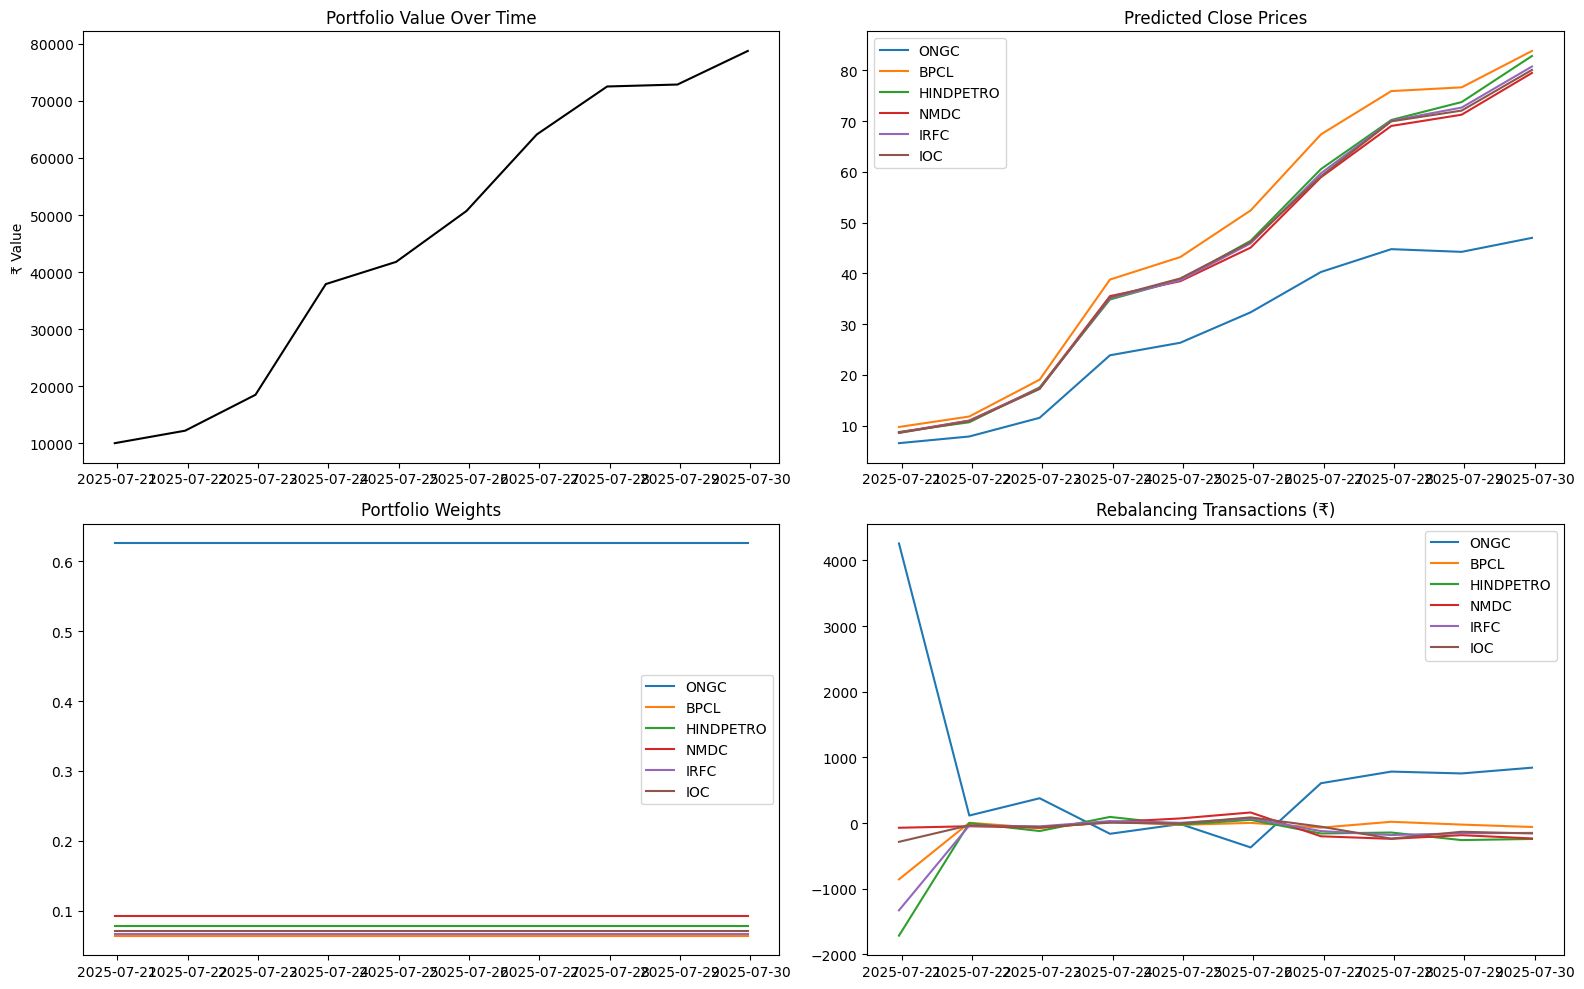

In [24]:
if __name__ == "__main__":
    # Load model
    model = PortfolioOptimization(num_assets=6, num_features=4, hidden_dim=128, input_seq_len=9).to(device)
    model.load_state_dict(torch.load("rl_portfolio_optimization.pth", map_location=device))

    # Initial sequence: shape [10, 6, 4]
    initial_sequence = torch.randn(9, 6, 4)  # Replace with real data
    initial_weights = [0.2, 0.15, 0.25, 0.1, 0.2, 0.1]  # Must sum to 1

    pred_df, weight_df, transaction_df, value_df = predict_with_reallocation(
        model,
        initial_sequence=initial_sequence,
        initial_weights=initial_weights,
        num_days=10,
        initial_capital=10000
    )

    save_and_plot(pred_df, weight_df, transaction_df, value_df)


In [25]:
import pandas as pd
df=pd.read_excel("portfolio_reallocation_result.xlsx")
df.head()

,Unnamed: 0,ONGC,BPCL,HINDPETRO,NMDC,IRFC,IOC
0,2025-07-20 23:06:24.150,6.570180,9.759683,8.772034,8.679111,8.621272,8.589504
1,2025-07-21 23:06:24.150,7.887610,11.820204,10.689087,11.031272,10.982769,10.883068
2,2025-07-22 23:06:24.150,11.568363,19.080875,17.560528,17.400591,17.329033,17.249620
3,2025-07-23 23:06:24.150,23.882578,38.801418,34.873127,35.536888,35.106800,35.292862
4,2025-07-24 23:06:24.150,26.352734,43.231628,38.740704,38.478954,38.663170,39.022469
